# Modeling and simulation of a room on the top floor with a nonlinear controlled heater
**Author:** Lukas Lüthi
**Institution:** ZHAW School of Engineering IEFE
**Course/Module:** CE4IB
**Date:** 31 Oct 2025

# Table of contents

# Description of the room

The simulation domain that is used for this model is a single room. This room is at the top floor of its corresponding building.

# Defining the simulation parameters

## Define the setup

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Personal_Project.dm4bem as dm4bem

In [27]:
n_occupants = 2

ave_Q_at_home = 200 # W

controller = True
nonlinear_controller = True

consider_s2s_radiation = True

imposed_time_step = False
delta_t = 500    # s, imposed time step

calculate_step_response = False

output_nodes = [25]

## Outside conditions

In [28]:
To_ss = 10          # °C
To_stp = 10         # °C

# input for weather data
date_start = '2024-10-16 00:00:00'
date_end = '2025-06-30 23:59:59'
print(f'{date_start} \tstart date')
print(f'{date_end} \tend date')

2024-10-16 00:00:00 	start date
2025-06-30 23:59:59 	end date


## Controller

In [29]:
Tisp = 22     # °C

# input for the dynamic simulation
Ti_day = 22
Ti_night = 20

if controller:
    Kp = 1e3
else:
    Kp = 0

def nl_controller(u, theta_exp, k, Kp, *, t_inside='θ25', tisp_col='q39'):
    theta_i = float(theta_exp.iloc[k][t_inside])
    Tisp = float(u.iloc[k][tisp_col])

    # heating
    if theta_i < Tisp:
        u.at[u.index[k], t_inside] += Kp * (Tisp - theta_i)

    # cooling
    if theta_i > Tisp+3:
        u.at[u.index[k],'θ8'] *= 0.2
        u.at[u.index[k],'θ18'] *= 0.2
        u.at[u.index[k],'θ24'] *= 0.2

## Ventilation

In [30]:
ACH = 1

## Material properties

In [31]:
# concrete
lam_concrete = 1.4                          # W/(m⋅K)
c_concrete = 880.0                          # J/(kg⋅K)
rho_concrete = 2300.0                       # kg/m3

# insulation
lam_insulation = 0.004                      # W/(m⋅K)
c_insulation = 1210.0                       # J/(kg⋅K)
rho_insulation = 55.0                       # kg/m3

# ceiling
lam_ceiling = 0.7                           # W/(m⋅K)
c_ceiling = 1000.0                          # J/(kg⋅K)
rho_ceiling = 200.0                         # kg/m3

# windows
u_window = 1.2                              # W/(m²⋅K)
tau_window = 0.3                            # transmittance

# air
cp_air = 1006                               # J/(kg⋅K)
rho_air = 1.2                               # kg/m3

## Convection coefficients

In [32]:
h_in = 7.7                                  # W/(m²⋅K)
h_out = 25                                  # W/(m²⋅K)

h_c_in = 7.7                                # W/(m²⋅K)
h_c_out = 25                                # W/(m²⋅K)

## Geometry

In [33]:
height_room = 2.5                             # m

w_concrete = 0.4                            # m
w_insulation = 0.05                         # m
w_ceiling = 0.8                             # m

width_wall1 = 5.3                             # m
width_wall2 = 9.5                            # m
width_wall3 = 9.2                            # m
width_wall4 = 3.3                             # m

width_windows = 2.5                           # m

A_window_1 = width_windows*height_room      # m²
A_wall_1 = width_wall1*height_room-A_window_1       # m²

A_window_2 = width_windows*height_room * 2  # m²
A_wall_2 = width_wall2*height_room-A_window_2      # m²

A_ceiling = width_wall1*width_wall3 - width_wall3*(width_wall1-width_wall4)/2   # m²

angle_wall = 80                             # °

# Orientation definition
wall_1_orientation = {'slope': 90,
                      'azimuth': -90,
                      'latitude': 45}
albedo_wall_1 = 0.55

wall_2_orientation = {'slope': 90,
                      'azimuth': 90-angle_wall,
                      'latitude': 45}
albedo_wall_2 = 0.55

ceiling_orientation = {'slope': 180,
                       'azimuth': 0,
                       'latitude':45}
albedo_ceiling = 0.55

## Radiation properties

In [34]:
alpha_wall_a = 0.7
alpha_wall_i = 0.2
alpha_ceiling_a = 0.65

eps_i = 0.96
eps_a_w = 0.8
eps_a_c = 0.7

# check calculation ------------------------------------------------------------------------------------
A12 = width_wall1/width_wall2
F12 = (A12+1-np.sqrt(A12**2+1-2*A12*np.cos((angle_wall/360) * 2*np.pi)))/2
H1c = width_wall2/height_room
F1c = 0.5*(1+H1c - np.sqrt(1+H1c**2))
H2c = width_wall1/height_room
F2c = 0.5*(1+H2c - np.sqrt(1+H2c**2))

# Defining the matrices and vectrors

## A

In [35]:
n_nodes = 28
n_flows = 42

A = np.zeros((n_flows+1, n_nodes+1))
A[0,0] = 1
A[1,0] = -1; A[1,1] = 1
A[2,1] = -1; A[2,2] = 1
A[3,2] = -1; A[3,3] = 1
A[4,3] = -1; A[4,4] = 1
A[5,4] = -1; A[5,5] = 1
A[6,5] = -1; A[6,6] = 1
A[7,6] = -1; A[7,7] = 1
A[8,7] = -1; A[8,8] = 1
A[9,8] = -1; A[9,25] = 1
A[10,27] = -1; A[10,26] = 1
A[11,9] = 1
A[12,9] = -1; A[12,25] = 1
A[13,8] = -1; A[13,19] = 1
A[14,9] = -1; A[14,18] = 1
A[15,10] = 1
A[16,10] = -1; A[16,11] = 1
A[17,11] = -1; A[17,12] = 1
A[18,12] = -1; A[18,13] = 1
A[19,13] = -1; A[19,14] = 1
A[20,14] = -1; A[20,15] = 1
A[21,15] = -1; A[21,16] = 1
A[22,16] = -1; A[22,17] = 1
A[23,17] = -1; A[23,18] = 1
A[24,18] = -1; A[24,25] = 1
A[25,9] = -1; A[25,19] = 1
A[26,19] = 1
A[27,19] = -1; A[27,25] = 1
A[28,20] = 1
A[29,20] = -1; A[29,21] = 1
A[30,21] = -1; A[30,22] = 1
A[31,22] = -1; A[31,23] = 1
A[32,23] = -1; A[32,24] = 1
A[33,28] = -1; A[33,26] = 1
A[34,24] = -1; A[34,9] = 1
A[35,28] = -1; A[35,27] = 1
A[36,24] = -1; A[36,19] = 1
A[37,24] = -1; A[37,25] = 1
A[38,25] = 1
A[39,25] = 1
A[40,26] = -1; A[40,8] = 1
A[41,27] = -1; A[41,18] = 1
A[42,24] = -1; A[42,28] = 1


## G

In [36]:
G = np.zeros(n_flows+1)

# wall 1
G[0] = h_out*A_wall_1

# conduction concrete
for i in [5,6,7,8]:
    G[i] = lam_concrete*A_wall_1/w_concrete

# conduction insulation
for i in [1,2,3,4]:
    G[i] = lam_insulation*A_wall_1/w_insulation

G[9] = h_in*A_wall_1

# window 1
G[11] = u_window*A_window_1
G[12] = h_in*A_window_1

# wall 2
G[15] = h_out*A_wall_2

# conduction concrete
for i in [20,21,22,23]:
    G[i] = lam_concrete*A_wall_2/w_concrete

# conduction insulation
for i in [16,17,18,19]:
    G[i] = lam_insulation*A_wall_2/w_insulation

G[24] = h_in*A_wall_2

# window 2
G[26] = u_window*A_window_2
G[27] = h_in*A_window_2

# ceiling
G[28] = h_c_out*A_ceiling

for i in [29,30,31,32]:
    G[i] = lam_ceiling*A_ceiling/w_ceiling

G[37] = h_c_in*A_ceiling

# Ventilation
V_a = A_ceiling*height_room
V_dot_a = ACH*V_a/3600
G[38] = rho_air*V_dot_a*cp_air

# perfect Controller
if not nonlinear_controller:
    G[39] = Kp

# LW radiation
if consider_s2s_radiation:
# Assuming T_mean = 20°C so 4σT³ = 5.7 W/(m²·K)
    coeff = 5.7

    G[10] = coeff*F12*A_wall_1
    G[33] = coeff*F1c*A_wall_1
    G[35] = coeff*F2c*A_wall_2

    G[40] = coeff * eps_i/(1-eps_i) * A_wall_1
    G[41] = coeff * eps_i/(1-eps_i) * A_wall_2
    G[42] = coeff * eps_i/(1-eps_i) * A_ceiling


## C

In [37]:
C = np.zeros(n_nodes+1)

# wall 1
for i in [5,6,7]:
    C[i] = c_concrete*rho_concrete*w_concrete*A_wall_1 / 3

for i in [1,2,3]:
    C[i] = c_insulation*rho_insulation*w_insulation*A_wall_1 / 3

# wall 2
for i in [15,16,17]:
    C[i] = c_concrete*rho_concrete*w_concrete*A_wall_2 / 3

for i in [11,12,13]:
    C[i] = c_insulation*rho_insulation*w_insulation*A_wall_2 / 3

# ceiling
for i in [21,22,23]:
    C[i] = c_ceiling*rho_ceiling*w_ceiling*A_ceiling / 3

C[25] = cp_air*rho_air*V_a

## b for steady state

In [38]:
b_ss = np.zeros(n_flows+1)

for i in [0,11,15,26,28,38]:
    b_ss[i] = To_ss

b_ss[39] = Tisp


## f for steady state

In [39]:
f_ss = np.zeros(n_nodes+1)


## y

In [40]:
y = np.zeros(n_nodes+1)

for i in output_nodes:
    y[i] = 1

# Solving the steady state

In [41]:
diag_G = np.diag(G)

theta_ss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ b_ss + f_ss)
print(f'Temperature inside: {np.around(theta_ss[25], 2)} °C')

Temperature inside: 10.0 °C


# Dynamic simulation

## b and f sources for a dynamic simulation

In [42]:
b = np.zeros(n_flows+1)
f = np.zeros(n_nodes+1)

## Assemble the thermal circuit

In [43]:
node_labels = [f"θ{i}" for i in range(n_nodes+1)]
flow_labels = [f"q{i}" for i in range(n_flows+1)]

A = pd.DataFrame(A, index=flow_labels, columns=node_labels)
G = pd.Series(G, index=flow_labels, name="G")
C = pd.Series(C, index=node_labels, name="C")
b = pd.Series(b, index=flow_labels, name="b").astype("object")
f = pd.Series(f, index=node_labels, name="f").astype("object")
y = pd.Series(y, index=node_labels, name="y")

for i in [0,11,15,26,28,38]:
    b[f"q{i}"] = "To"
b["q39"] = "Tisp"

f["θ0"] = "phi_1_o"; f["θ8"] = "phi_1_i"
f["θ10"] = "phi_2_o"; f["θ18"] = "phi_2_i"
f["θ20"] = "phi_c_o"; f["θ24"] = "phi_c_i"
f["θ25"] = "Q_dot"

TC = {
    "A": A,
    "G": G,
    "C": C,
    "b": b,
    "f": f,
    "y": y,
}

[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

## Eigenvalues analysis

In [44]:
lam_eigen = np.linalg.eig(As)[0]

# time step
delta_tmax = 2 * min(-1. / lam_eigen)
dm4bem.print_rounded_time('Δtmax', delta_tmax)

if imposed_time_step:
    dt = delta_t
else:
    if nonlinear_controller:
        dt = dm4bem.round_time(delta_tmax) * 0.05            # reducing the max time step by 0.5 for stability reasons
    else:
        dt = dm4bem.round_time(delta_tmax) * 0.5
dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1 / lam_eigen)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

Δtmax = 1839 s = 30.7 min
dt = 90 s = 1.5 min
t_settle = 2786142 s = 773.9 h
duration = 2786400 s = 774.0 h


## Step response

In [45]:
if calculate_step_response:

    # Create input_data_set

    n_stp = int(np.floor(duration / dt))    # number of time steps
    time_stp = pd.date_range(start="2000-01-01 00:00:00",
                               periods=n_stp, freq=f"{int(dt)}s")

    print(f'Number of time steps: {n_stp}')

    To_stp = To_stp * np.ones(n_stp)
    Ti_sp_stp = Tisp * np.ones(n_stp)
    phi_1_o_stp = 0 * np.ones(n_stp)
    Q_dot_stp = phi_1_i_stp = phi_2_o_stp = phi_2_i_stp = phi_c_o_stp = phi_c_i_stp = phi_1_o_stp

    data_stp = {'To': To_stp, 'Tisp': Ti_sp_stp, 'phi_1_o': phi_1_o_stp, 'phi_1_i': phi_1_i_stp,
                'phi_2_o': phi_2_o_stp, 'phi_2_i': phi_2_i_stp, 'phi_c_o': phi_c_o_stp,
                'phi_c_i': phi_c_i_stp, 'Q_dot': Q_dot_stp}
    input_data_set_stp = pd.DataFrame(data_stp, index=time_stp)
    u_stp = dm4bem.inputs_in_time(us, input_data_set_stp)


    # Initial conditions
    theta_exp_stp = pd.DataFrame(index=u_stp.index)     # empty df with index for explicit Euler
    theta_imp_stp = pd.DataFrame(index=u_stp.index)     # empty df with index for implicit Euler

    theta_0 = 0.0                    # initial temperatures
    theta_exp_stp[As.columns] = theta_0      # fill θ for Euler explicit with initial values θ0
    theta_imp_stp[As.columns] = theta_0      # fill θ for Euler implicit with initial values θ0

    I = np.eye(As.shape[0])     # identity matrix
    for k in range(u_stp.shape[0] - 1):
        theta_exp_stp.iloc[k + 1] = (I + dt * As)\
            @ theta_exp_stp.iloc[k] + dt * Bs @ u_stp.iloc[k]
        theta_imp_stp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
            @ (theta_imp_stp.iloc[k] + dt * Bs @ u_stp.iloc[k])

    # outputs
    y_exp_stp = (Cs @ theta_exp_stp.T + Ds @  u_stp.T).T
    y_imp_stp = (Cs @ theta_imp_stp.T + Ds @  u_stp.T).T

### Plot the data

In [46]:
if calculate_step_response:
    # plot results
    y_stp = pd.concat([y_exp_stp, y_imp_stp], axis=1, keys=['Explicit', 'Implicit'])
    # Flatten the two-level column labels into a single level
    y_stp.columns = y_stp.columns.get_level_values(0)

    ax = y_stp.plot()
    ax.set_xlabel('Time')
    ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
    ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {delta_tmax:.0f} s')
    #ax.set_xlim(["2000-01-01 00:00:00", "2000-01-02 00:00:00"])
    plt.show()

## Dynamic simulation with weather data

### Input data set

In [47]:
# weather data
filename = './Personal_Project/weather_data/CHE_AG_Wuerenlingen.066470_TMYx.2009-2023.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2025))
weather = weather.loc[date_start:date_end]

# Temperature sources
To = weather['temp_air']
Ti_sp = pd.Series(20, index=To.index)
Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

# total solar irradiance wall1

rad_wall1 = dm4bem.sol_rad_tilt_surf(
    weather, wall_1_orientation, albedo_wall_1)

Etot_wall1 = rad_wall1.sum(axis=1)

# total solar irradiance wall2
rad_wall2 = dm4bem.sol_rad_tilt_surf(
    weather, wall_2_orientation, albedo_wall_2)

Etot_wall2 = rad_wall2.sum(axis=1)

# total solar irradiance ceiling
rad_ceiling = dm4bem.sol_rad_tilt_surf(
    weather, ceiling_orientation, albedo_ceiling)

Etot_ceiling = rad_ceiling.sum(axis=1)

# Flow sources
phi_1_o = alpha_wall_a*A_wall_1*Etot_wall1
phi_2_o = alpha_wall_a*A_wall_2*Etot_wall2
phi_c_o = alpha_ceiling_a*A_ceiling*Etot_ceiling

Rad_tot_i = tau_window*alpha_wall_i*A_window_1*Etot_wall1 + tau_window*alpha_wall_i*A_window_2*Etot_wall2
A_i_tot = A_wall_1+A_wall_2+A_ceiling

phi_1_i = Rad_tot_i * A_wall_1/A_i_tot
phi_2_i = Rad_tot_i * A_wall_2/A_i_tot
phi_c_i = Rad_tot_i * A_ceiling/A_i_tot

Q_dot = pd.Series(
    [0 if 7 <= hour <= 18 else ave_Q_at_home*n_occupants for hour in To.index.hour],
    index=To.index)

# Input data set
input_data_set = pd.DataFrame({'To': To, 'Tisp': Ti_sp, 'phi_1_o': phi_1_o, 'phi_1_i': phi_1_i,
            'phi_2_o': phi_2_o, 'phi_2_i': phi_2_i, 'phi_c_o': phi_c_o,
            'phi_c_i': phi_c_i, 'Q_dot': Q_dot})

print(f'Number of time steps: {input_data_set.size}')

Number of time steps: 39096


### Time integration

In [48]:
# Resample hourly data to time step dt
input_data_set = input_data_set.resample(
    str(dt) + 's').interpolate(method='linear')

# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# initial conditions
theta_0 = input_data_set["Tisp"].iloc[0]     # initial temperatures
theta_exp = pd.DataFrame(index=u.index, dtype="float64")
theta_exp[As.columns] = theta_0      # Fill theta with initial values θ0
theta_exp = theta_exp.astype("float64")

# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(1, u.shape[0] - 1):
    if nonlinear_controller:
        nl_controller(u,theta_exp, k, Kp)
    theta_exp.iloc[k + 1] = (I + dt * As)\
        @ theta_exp.iloc[k] + dt * Bs @ u.iloc[k]

# outputs
y = (Cs @ theta_exp.T + Ds @  u.T).T

q_heating = (Kp * (u['q39'] - y['θ25'])).clip(lower=0)

Phi_i_tot = u['θ8'] + u['θ18'] + u['θ24']

### Plotting the results

Plot of the inside and outside Temperature and the heat rate

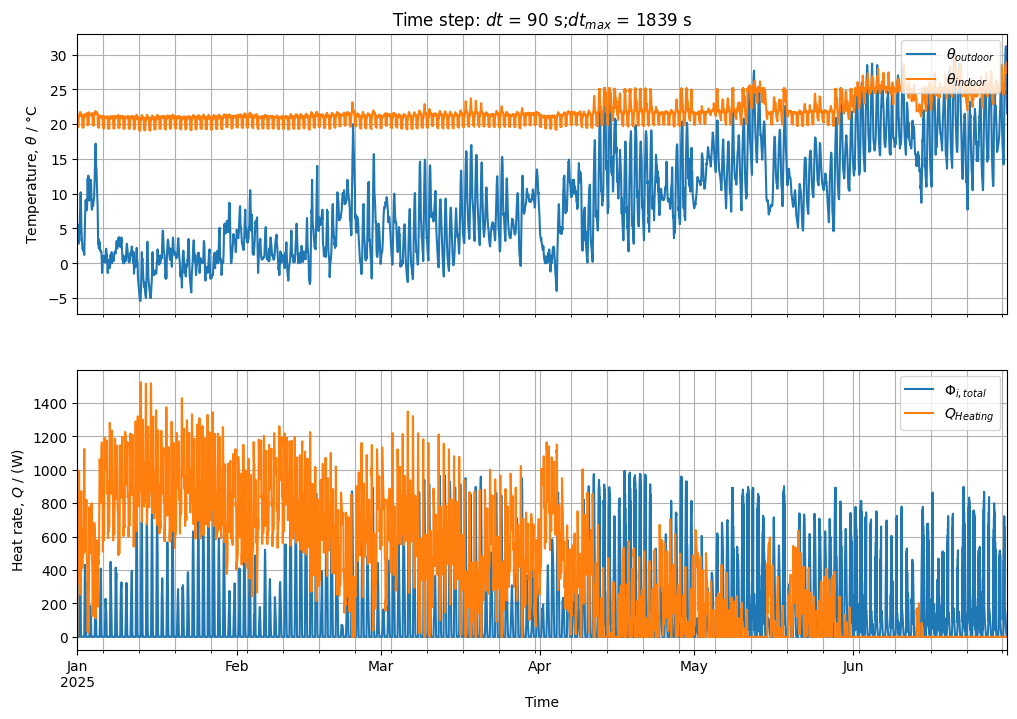

Min. indoor temperature: 19.1 °C
Max. indoor temperature: 29.6 °C
Max. load: 1523.0 W at 2025-01-13 07:03:00+01:00
Energy consumption: 1708.1 kWh


In [49]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ25'],
                     'Phi_i_tot': Phi_i_tot,
                     'q_heating': q_heating})

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Phi_i_tot', 'q_heating']].plot(ax=axs[1],
                              ylabel='Heat rate, $Q$ / (W)')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{i,total}$', '$Q_{Heating}$'],
              loc='upper right')
axs[0].set_title(f'Time step: $dt$ = {dt:.0f} s;'
                 f'$dt_{{max}}$ = {delta_tmax:.0f} s')
for ax in axs:
    ax.grid(True, which='both')
plt.show()

print(f'Min. indoor temperature: {data["θi"].min():.1f} °C')
print(f'Max. indoor temperature: {data["θi"].max():.1f} °C')

max_load = data['q_heating'].max()
max_load_index = data['q_heating'].idxmax()
print(f"Max. load: {max_load:.1f} W at {max_load_index}")
print(f"Energy consumption: {(data['q_heating'] * dt).sum() / (3.6e6):.1f} kWh")

Plot of the solar radiation on the surfaces

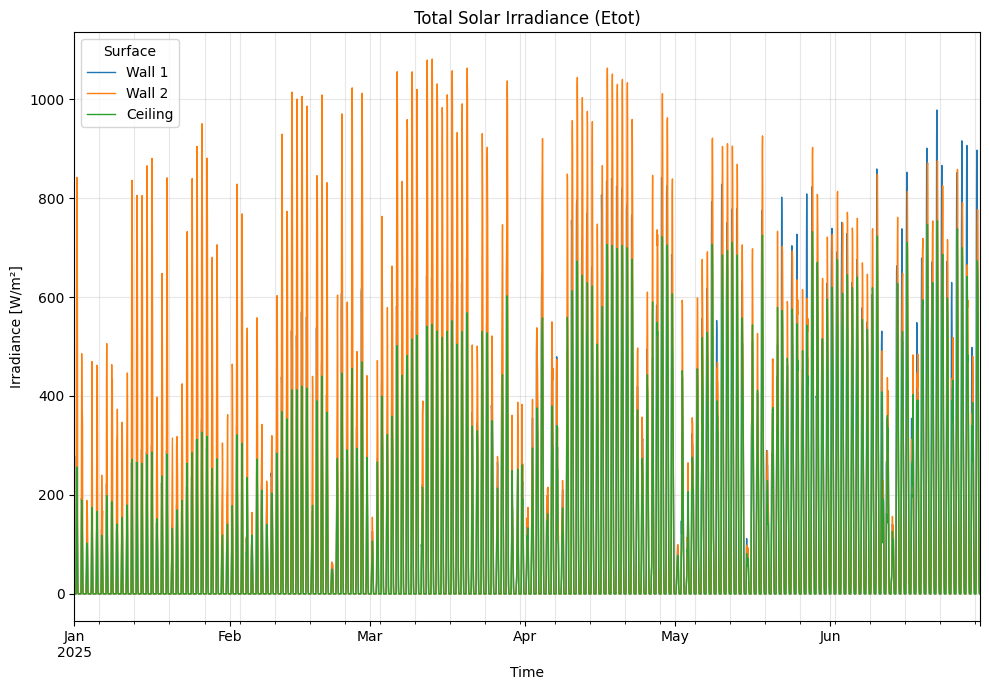

In [50]:
# Combine into one DataFrame (auto-aligns on the datetime index)
data_etot = pd.DataFrame({
    "Wall 1": Etot_wall1,
    "Wall 2": Etot_wall2,
    "Ceiling": Etot_ceiling,
}).sort_index()

# --- Line plot of total solar irradiance (instantaneous, e.g., W/m²) ---
fig, ax = plt.subplots(figsize=(10, 7))
data_etot.plot(ax=ax, linewidth=1)
ax.set_title("Total Solar Irradiance (Etot)")
ax.set_xlabel("Time")
ax.set_ylabel("Irradiance [W/m²]")
ax.grid(True, which="both", alpha=0.3)
ax.legend(title="Surface", loc="best")
plt.tight_layout()
plt.show()